# 2. Extracción de características

En esta sección vamos a presentar las características que podemos extraer tanto del dominio temporal como del dominio frecuencial de un audio. En base a estas características daremos una intuición de cómo se pueden distinguir géneros musicales a nivel exploratorio/cualitativo, antes de proceder a la próxima sección donde utilizaremos modelos de aprendizaje.

## Importaciones

In [14]:
import librosa

import numpy as np

import matplotlib.pyplot as plt

import IPython.display as ipd
import pandas as pd
import os

___

## 2.1. Explicación de las características

Cuando analizamos una señal de audio, podemos hacerlo desde dos perspectivas principales: el dominio temporal y el dominio frecuencial. Cada uno de estos dominios nos brinda diferentes tipos de información sobre el audio.

### Análisis de una señal de audio: dominio temporal, dominio frecuencial y dominio tempofrecuencial

Hagamos un breve repaso sobre los distintos dominios en los que podemos analizar una señal.

**Dominio temporal: tiempo vs amplitud**

Cuando analizamos el dominio temporal de una señal estamos analizando cómo varía la amplitud de la señal de audio a lo largo del tiempo ("la intensidad de la señal en cada momento"). En este caso:
* **Eje X - tiempo**. El eje horizontal representa el avance temporal medido en segundos.
* **Eje Y - amplitud**. El eje vertical representa la amplitud de la señal, es decir, la desviación de la onda con respecto al eje central. En el dominio temporal se mide como un valor sin dimensiones (adimensional) que oscila entre -1 y 1 en formatos normalizados o como una señal de número entero (por ejemplo, entre -32768 y 32767 señales para 16-bit) en formatos no normalizados. Representa la fuerza o intensidad de la señal.

**Dominio frecuencial: frecuencia vs magnitud**

Cuando analizamos el dominio frecuencial de una señal, estamos analizando la magnitud de cada frencuencia de la señal. En este caso:

* **Eje X - frecuencia.** El eje horizontal representa las frecuencias presentes en la señal, medidas en Hertz (Hz). 
* **Eje Y - magnitud/amplitud.** El eje vertical representa la magnitud de cada frecuencia. Es el módulo del número complejo que representa la contribución de cada frecuencia a la señal global.

Este gráfico representa de forma clara la dicotomía entre ambos dominios.

<img src="img/NB2_timeFreqDomain.png" width="600"/>

*Figura: Dominio temporal vs dominio frecuencial. Fuente: [[1]](https://studyelectrical.com/2023/05/time-domain-analysis-vs-frequency-domain-analysis.html)*

Veamos a continuación un ejemplo práctico utilizando un audio de ejemplo del corpus CCMUSIC:

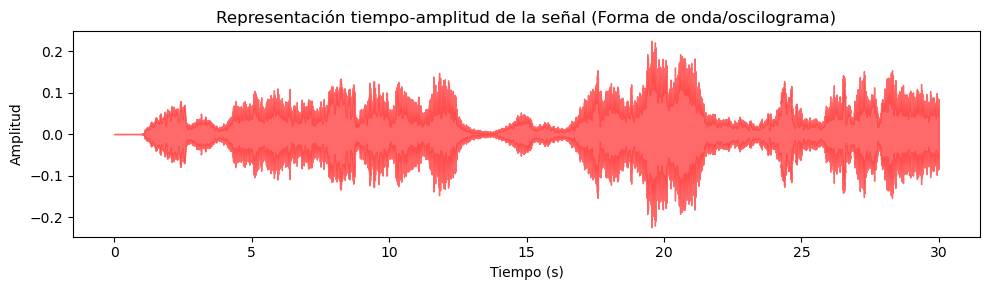

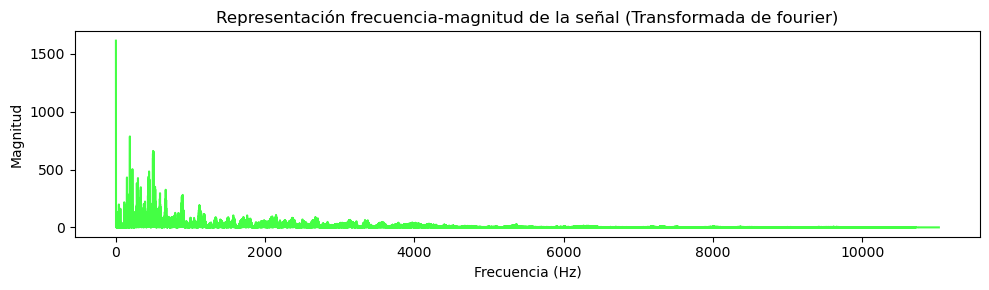

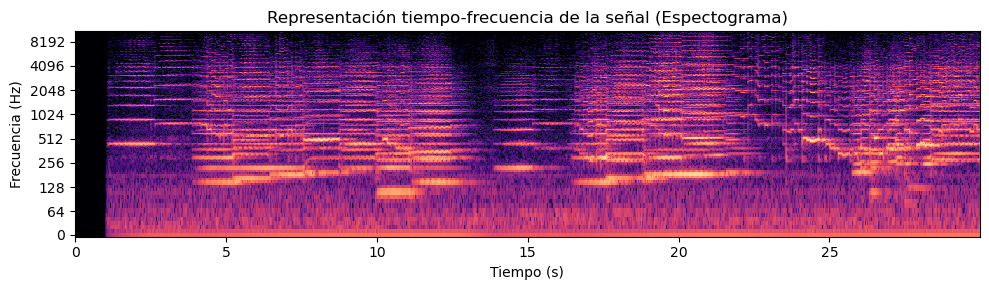

In [15]:
file_ejemplo = "ccmusic/train/audios/audio_train_653.wav"
audio, sr = librosa.load(file_ejemplo, sr=None, mono=True)

# Reproducir el audio
ipd.display(ipd.Audio(audio, rate=sr))

# Dominio temporal
plt.figure(figsize=(10, 3))
librosa.display.waveshow(audio, sr=sr, color="#f44", alpha=0.8)
plt.title("Representación tiempo-amplitud de la señal (Forma de onda/oscilograma)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

# Dominio frecuencial
fft = np.fft.fft(audio)
frequencies = np.fft.fftfreq(len(fft), 1/sr) # *** Explicación abajo ***
magnitude = np.abs(fft)

plt.figure(figsize=(10, 3))
plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(frequencies)//2], color="#4f4") # Representamos solo la mitad dado que el gráfico es simétrico
plt.title("Representación frecuencia-magnitud de la señal (Transformada de fourier)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.tight_layout()
plt.show()

# Frecuencia + tipo
D = np.abs(librosa.stft(audio))
plt.figure(figsize=(10, 3))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.title("Representación tiempo-frecuencia de la señal (Espectograma)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.tight_layout()
plt.show()

# *** Explicación ***
# np.fft.fftfreq genera un array de frecuencias que corresponde a los componentes de la transformada de Fourier.
# El primer argumento es la longitud de la transformada (igual a la longitud de la señal original).
# El segundo argumento, 1/sr, es el intervalo de tiempo entre muestras, que es el inverso de la tasa de muestreo (sr).
# Esto produce un array de frecuencias que se corresponde con los índices del resultado de np.fft.fft, permitiendo
# visualizar el espectro de frecuencias en Hertz.# 

### Segmentación en bloques

El procesamiento de señales en bloques, o frames, es fundamental en el análisis de audio y otros tipos de señales temporales. Esta técnica permite simplificar y y mejorar en eficiencia el análisis mediante la descomposición de la señal en segmentos manejables. Además, el solapamiento entre bloques ayuda a evitar discontinuidades en la información procesada, mejorando la calidad y la continuidad del análisis. Los parámetros comunes para este proceso son:

- **Tamaño de Frame**: Es el número de muestras que contiene cada bloque. Usualmente, este tamaño es un múltiplo de 2 debido a optimizaciones en la transformada de Fourier.
- **Separación HOP**: Es el intervalo de muestras entre el inicio de un frame y el inicio del siguiente. Si HOP es menor que el tamaño del FRAME, entonces los frames se solapan, lo que puede ayudar a mejorar la continuidad y calidad del análisis.


### Temporización de bloques (frames)

Considerando una señal con muestras $s_i$ ($i=0,..,N-1$) recogidas a una frecuencia de muestreo $sr$, los instantes temporales de cada muestra se calculan como $i\cdot 1/sr$. Al segmentar esta señal en bloques de tamaño $F \geq 1$ y con una separación $H \leq F$, podemos describir el proceso de temporización de los bloques:

- **Inicio de cada bloque**: El instante de tiempo para el comienzo del primer frame de un bloque $k$-ésimo se determina como $H\cdot k/sr$.

Los parámetros $F$ (tamaño del frame) y $H$ (separación entre frames) tienen un impacto directo en cómo se realiza la segmentación:

- **Solapamiento**: Si $H < F$, existe un solapamiento entre frames consecutivos, lo que ayuda a preservar la continuidad entre los segmentos analizados.
- **Número total de bloques ($T$)**: Depende de cómo se quiera gestionar el final de la señal:
    - Si definimos $T = \lfloor \frac{N-F}{H} + 1 \rfloor$, aseguramos que cada bloque, incluido el último, tenga exactamente $F$ muestras, aunque esto podría dejar algunas muestras al final de la señal sin incluir.
    - Si optamos por $T = \lfloor \frac{N}{H} \rfloor$, el último bloque podría no estar completo. Una solución común es rellenar este último bloque con muestras adicionales para completarlo.

### Características del dominio temporal

* **Amplitude Envelope (AE)**:
    - La envolvente de una señal proporciona una representación más suave de su amplitud, lo que nos permite visualizar mejor cómo varía la intensidad de la señal a lo largo del tiempo.

    - Intuitivamente, es como representar el borde del oscilograma.

    - Matemáticamente, se calcula agrupando el oscilograma en $K$ bloques temporales. Para cada bloque temporal o *frame*, en lugar de tomar todos los valores de amplitud, se toma el máximo (dando esa impresión de borde en la representación final).  
    Esto queda representado por la siguiente fórmula, donde \(AE_k\) es la envolvente de amplitud del bloque \(k\), $F$ es el tamaño del bloque, y \(s(i)\) es la señal en el índice \(i\).
    $$AE_k = \max_{i=kF}^{(k+1)F - 1} s(i)$$

* **RMS (Root Mean Square)**:

    - La RMS (Root Mean Square) de una señal sirve para estimar la energía de la señal en distitnos puntos del tiempo, lo que puede ayudar a detectar silencios y la dinámica de la señal. Para calcular el RMS de una señal $s(i)$ segmentada en $k$ bloques de tamaño $F$, se calcula:

    - Matemáticamente, podemos calcularla agrupando en $K$ bloques de tamaño $F$, siendo nuestra señal $s(i)$ 
$$RMS_k=\sqrt{\frac{1}{F} \cdot \sum_{i=k \cdot F}^{(k+1)\cdot F-1}{s(i)^2}}$$

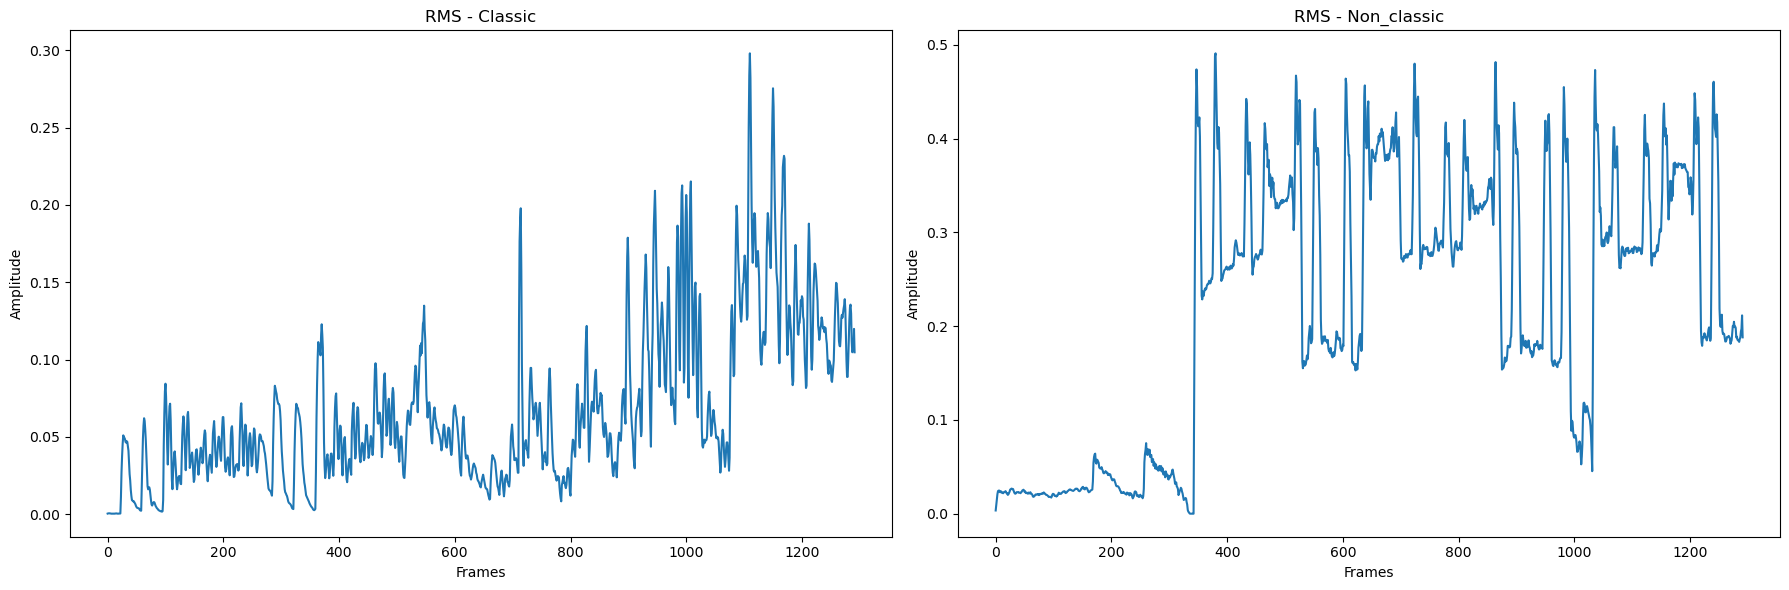

In [30]:
# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rms = librosa.feature.rms(y=audio_data)

    plt.subplot(1, 2, index+1)
    plt.plot(rms[0])
    plt.title(f'RMS - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

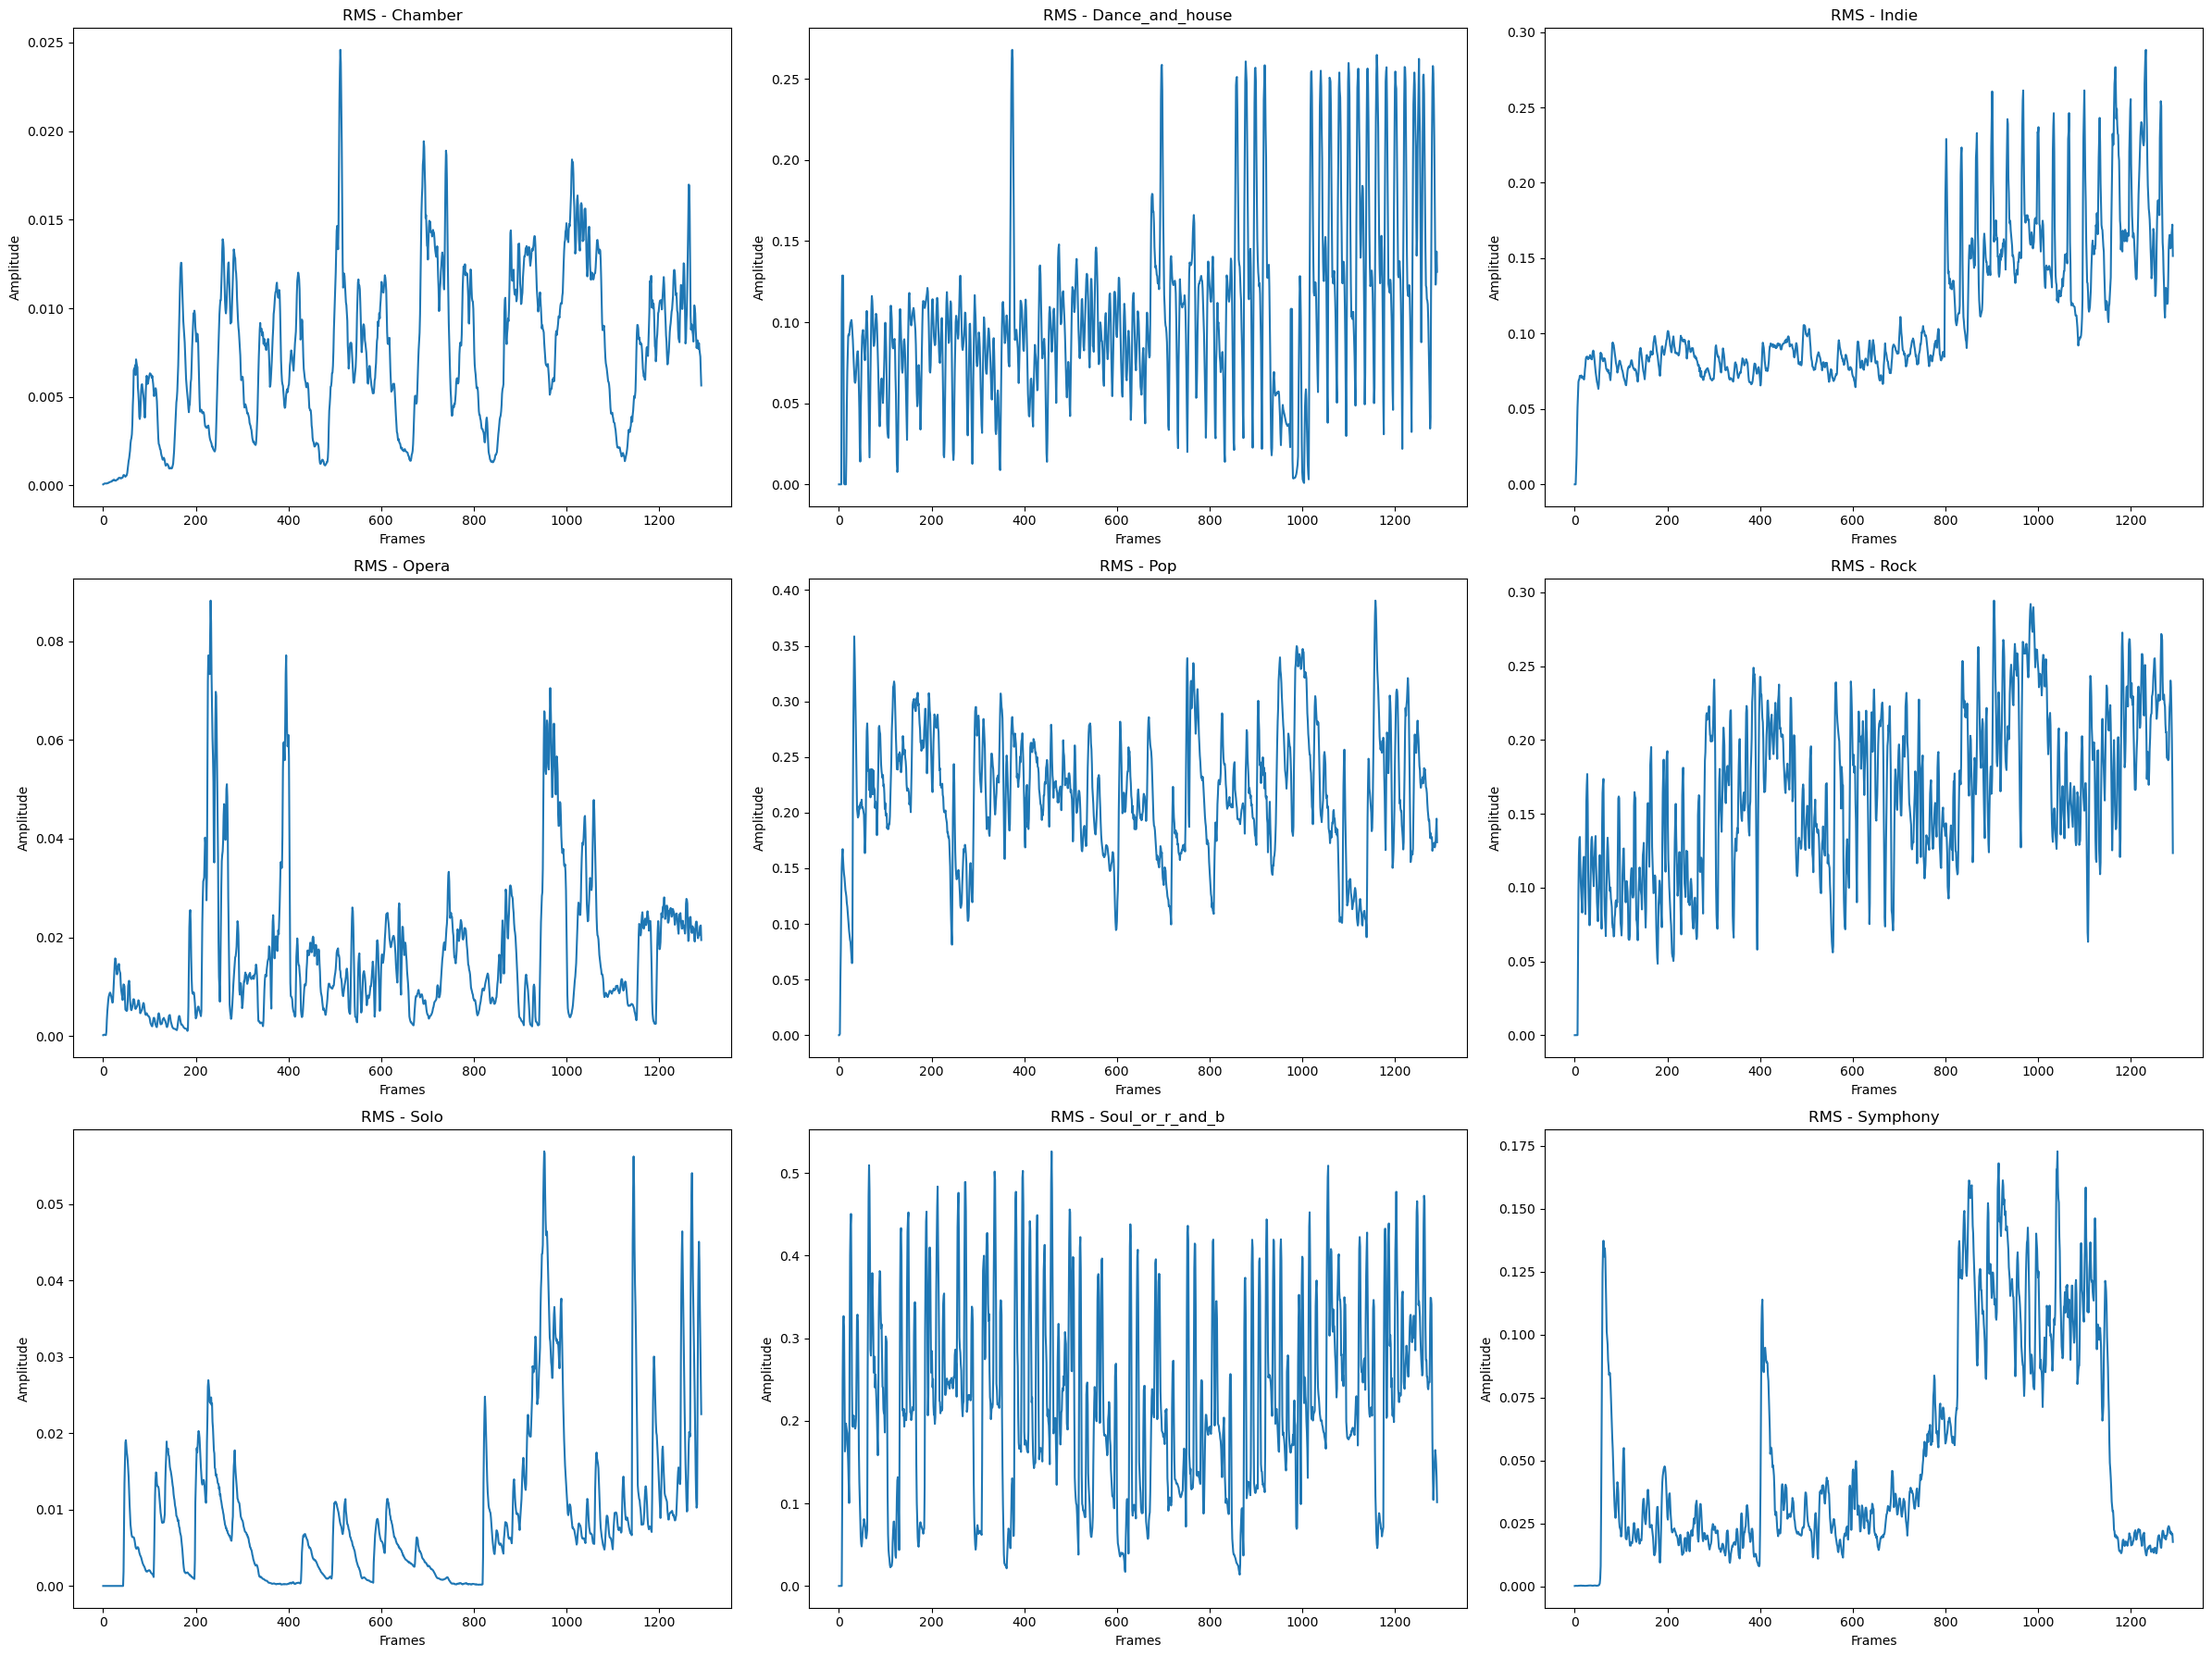

In [31]:
# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rms = librosa.feature.rms(y=audio_data)

    plt.subplot(3, 3, index+1)
    plt.plot(rms[0])
    plt.title(f'RMS - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

* **ZCR (Zero Crossing Rate)**:

    - La ZCR mide cuantas veces la señal de audio cruza el eje horizontal respecto a la longitud total de la señal, es decir, cuantas veces la amplitud pasa de negativa a positiva o viceversa.

    - Para calcular la ZCR de una señal $s(i)$ segmentada en $k$ bloques de tamaño $F$, se calcula:
    $$ZCR_k=\sum_{i=k \cdot F}^{(k+1)\cdot F-1} \frac{1}{2} | \text{sgn($s(i)$)- sgn($s(i+1)$)}  |$$
    donde la funcion signo se define: 
    $$ \text{sgn($z$)}=\begin{Bmatrix} 
        1  &  z>0 \\
        0  &  z=0 \\
        -1 &  z<0
        \end{Bmatrix}$$
    El resultado para cada bloque puede ser normalizado $ZCR_k/F$ para que sus valores estén entre [0,1]

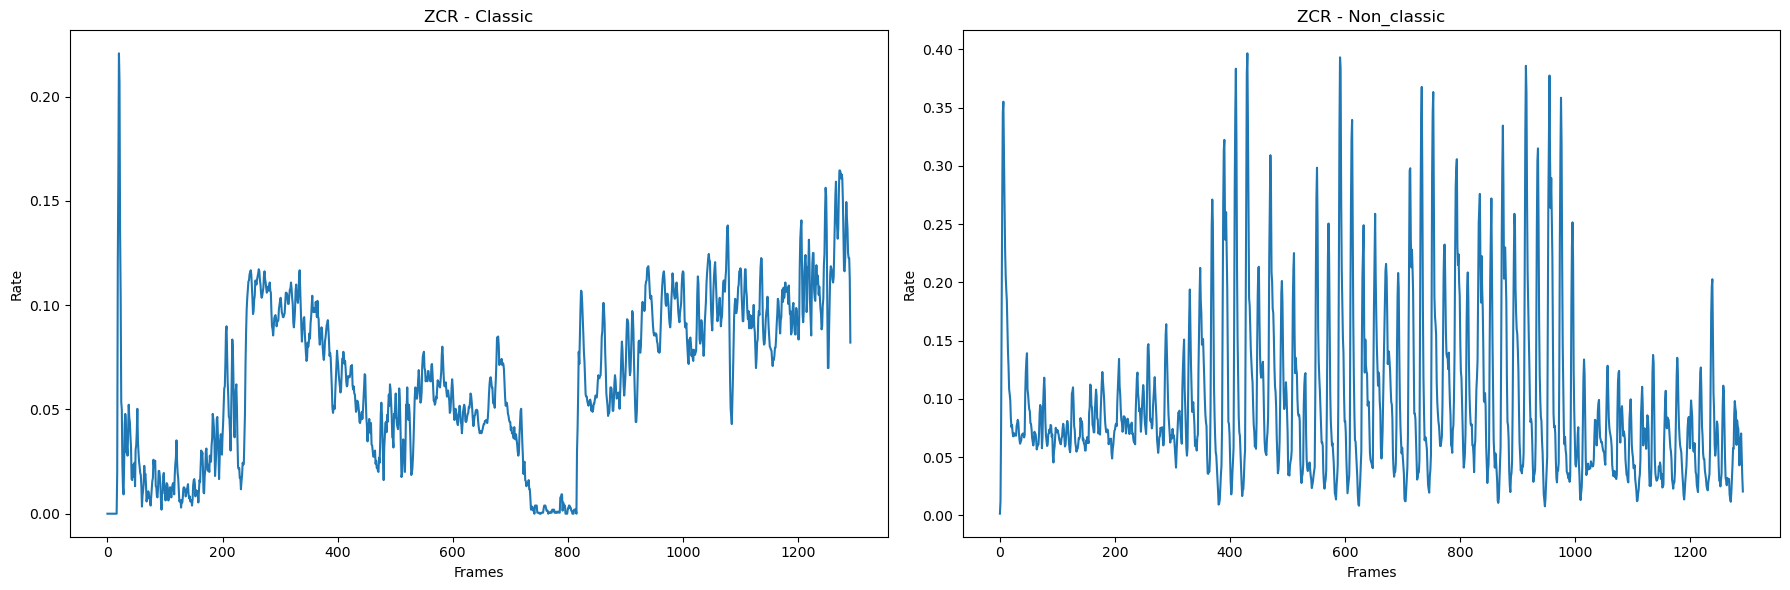

In [32]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)

    plt.subplot(1, 2, index+1)
    plt.plot(zcr[0])
    plt.title(f'ZCR - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Rate')

plt.tight_layout()
plt.show()

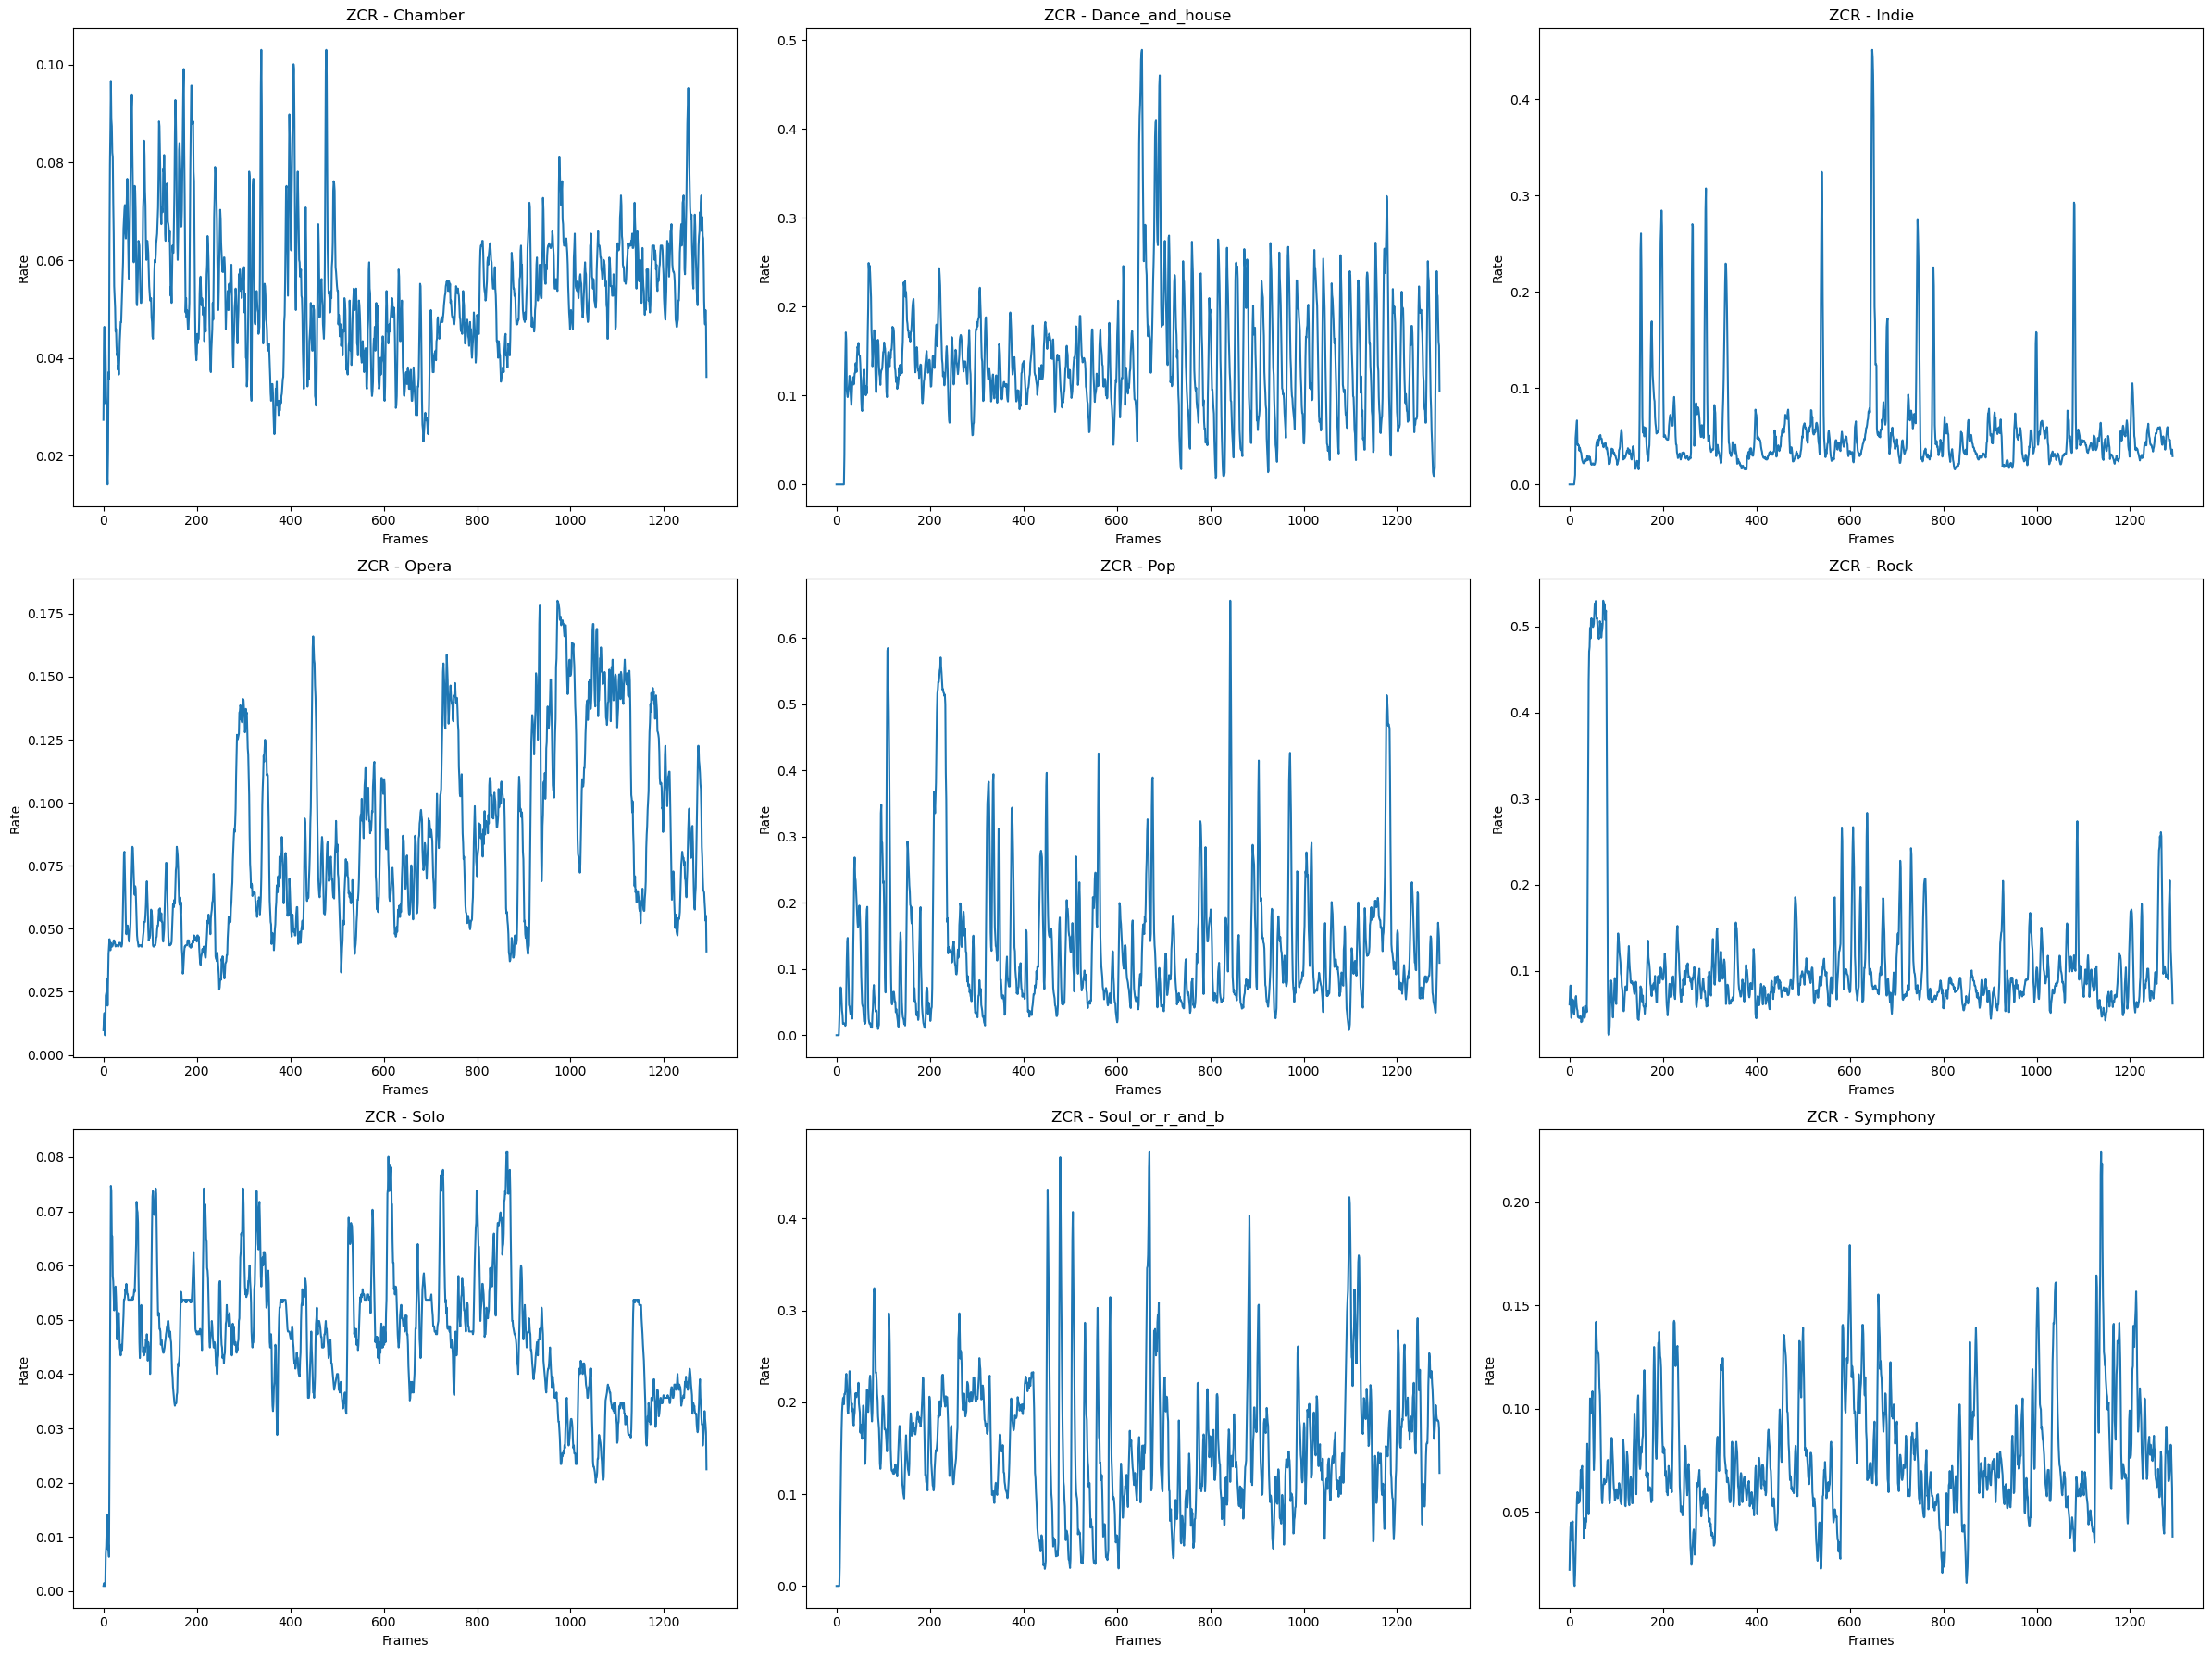

In [33]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)

    plt.subplot(3, 3, index+1)
    plt.plot(zcr[0])
    plt.title(f'ZCR - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Rate')

plt.tight_layout()
plt.show()

In [16]:
# def amplitude_envelope(signal,frame_size=1024,hop_length=512):
#     F=frame_size
#     H=hop_length
#     N=signal.shape[0]
#     return np.array([max(signal[k:k+F]) for k in range(0, N, H)])

### Características del dominio frecuencial

* **Band Energy Ratio (BER)**:
    - El BER mide la energía de la señal en diferentes bandas de frecuencia.
    - Es útil para distinguir entre sonidos graves y agudos.

* **Spectral Centroid**:
    - El *Spectral Centroid* indica el "centro de masa" del espectro de frecuencia.
    - Es un indicador de qué tan "brillante" o "oscuro" es el sonido.

* **Spectral Bandwidth**:
    - El *Spectral Bandwidth* mide la dispersión de las frecuencias.
    - Es útil para distinguir entre sonidos con diferentes texturas.

* **Chroma STFT**:
    - El Chroma STFT (Short-Time Fourier Transform) es una característica que representa la intensidad de las doce diferentes clases de tonos (notas musicales) en cada ventana de tiempo de una señal de audio. Esta técnica es esencialmente útil para analizar la música donde las dimensiones armónicas y melódicas son más relevantes. Utiliza la transformada de Fourier de tiempo corto para primero transformar la señal de tiempo a frecuencia y luego mapear esas frecuencias en 12 regiones que corresponden a las 12 notas de la escala cromática occidental.

    - Para calcular el Chroma STFT de una señal \(s(t)\), primero se realiza una transformada de Fourier de tiempo corto para obtener la representación en frecuencia de ventanas sucesivas de la señal:

$$ X(k, \omega) = \sum_{n=0}^{N-1} s(n + kH) \cdot w(n) \cdot e^{-j \omega n} $$

donde:
- $ k $ es el índice de la ventana temporal
- $ H $ es el tamaño del salto entre ventanas consecutivas
- $ w(n) $ es la ventana de análisis aplicada a la señal
- $ N $ es el número de puntos en la FFT
- $ \omega $ es la frecuencia angular

- Después, se mapea la magnitud del espectro obtenido $  |X(k, \omega)| $ a las 12 clases cromáticas utilizando un algoritmo que suma la energía de las frecuencias que caen dentro de cada clase tonal. Estas clases están divididas según la afinación temperada de los tonos musicales, que divide la octava en 12 tonos de igual razón de frecuencias. El resultado se normaliza y se convierte en un vector de 12 componentes que indica la fuerza relativa de cada clase tonal a lo largo del tiempo:

$$ C(k, m) = \sum_{\omega \in \text{bin}(m)} |X(k, \omega)| $$

donde:
- $m$ es el índice de una de las 12 clases cromáticas,
- $\text{bin}(m)$ es el conjunto de índices de frecuencia que corresponden a la clase tonal \(m\) en la escala temperada.

- El resultado, $ C(k, m) $, representa la intensidad de cada nota cromática en cada segmento de tiempo de la señal, proporcionando una potente herramienta para el análisis armónico y melódico en música.

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

    plt.subplot(1, 2, index+1)
    plt.imshow(chroma_stft, aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Chroma STFT - {label}')
    plt.xlabel('Time')
    plt.ylabel('Chroma Bins')

plt.tight_layout()
plt.show()

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

    plt.subplot(3, 3, index+1)
    plt.imshow(chroma_stft, aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Chroma STFT - {label}')
    plt.xlabel('Time')
    plt.ylabel('Chroma Bins')

plt.tight_layout()
plt.show()

* **Spectral Rolloff**:
    - El Spectral Rolloff es una medida del espectro de una señal de audio y representa el punto por debajo del cual se encuentra un cierto porcentaje de la energía total del espectro. Típicamente, este umbral se establece en el 85% pero puede ajustarse según sea necesario. El Spectral Rolloff es útil para determinar el límite superior de las frecuencias presentes en una señal, proporcionando una buena indicación de la presencia de altas frecuencias.

    - Para calcular el Spectral Rolloff de una señal $ s(t) $ a lo largo de ventanas temporales sucesivas, primero se realiza una transformada de Fourier de tiempo corto para obtener la representación en frecuencia de la señal:

    $$ X(k, \omega) = \sum_{n=0}^{N-1} s(n + kH) \cdot w(n) \cdot e^{-j \omega n} $$

    donde:
    - $ k $ es el índice de la ventana temporal
    - $ H $ es el tamaño del salto entre ventanas consecutivas
    - $ w(n) $ es la ventana de análisis aplicada a la señal
    - $ N $ es el número de puntos en la FFT
    - $ \omega $ es la frecuencia angular

    - A partir de la magnitud del espectro obtenido $ |X(k, \omega)| $, se calcula el rolloff como la frecuencia mínima para la cual la suma acumulada de la magnitud del espectro excede el 85% (u otro porcentaje especificado) del total de la energía espectral en esa ventana:

    $$ R(k) = \min \left( \omega : \sum_{i=0}^{\omega} |X(k, i)| \geq 0.85 \times \sum_{i=0}^{N-1} |X(k, i)| \right) $$

    donde:
    - $ R(k) $ es el valor de rolloff para la ventana \(k\)
    - $ |X(k, i)| $ es la magnitud del espectro en la frecuencia \(i\)
    - $ N-1 $ es el índice de la frecuencia más alta en la FFT.

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)

    plt.subplot(1, 2, index+1)
    plt.plot(rolloff[0])
    plt.title(f'Spectral Rolloff - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)

    plt.subplot(3, 3, index+1)
    plt.plot(rolloff[0])
    plt.title(f'Spectral Rolloff - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

____

## 2.2. Caso práctico: las características distinguen géneros muscicales

____

## 2.3. Extracción de características para el dataset CCMUSIC

En la actualidad es muy común el uso de espectogramas junto con redes convolucionales CNN para realizar clasificación de audio. No obstante, tradicionalmente, para entrenar modelos clásicos de Machine Learning se utilizaba extracción de características.

Al igual que en el caso del análisis de textos se utilizada el TfIdf junto con SVM ("bag of words"), en el análisis de audio se identificaba cada audio con una serie de características y se construía un dataset tabular (de ahí que hayamos titulado este proyecto "bag of songs").

En esta sección, vamos a extraer las características anteriores para cada audio y vamos a construir un dataset tabular que nos permita clasificar utilizando modelos clásicos y datos tabulares.

In [19]:
def amplitude_envelope(signal,frame_size=1024,hop_length=512):
    F=frame_size
    H=hop_length
    N=signal.shape[0]
    return np.array([max(signal[k:k+F]) for k in range(0, N, H)])



def calculate_ber(signal, split_freq, sample_rate, frame_size=1024, hop_length=512):

    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    range_of_freq = sample_rate / 2
    change_per_bin = range_of_freq / spec.shape[0]
    split_freq_bin = int(np.floor(split_freq / change_per_bin))

    modified_spec = np.abs(spec).T
    res = []
    for sub_arr in modified_spec:
        low_freq_density = sum(i ** 2 for i in sub_arr[:split_freq_bin])
        high_freq_density = sum(i ** 2 for i in sub_arr[split_freq_bin:])
        high_freq_density = high_freq_density if high_freq_density > 0 else 1e-10
        ber_val = low_freq_density / high_freq_density
        res.append(ber_val)
    return np.array(res)

In [20]:
def store_features(audio_path, label, csv_file):
    audio_data, sr = librosa.load(audio_path, sr=None)
    
    envelope = amplitude_envelope(audio_data)
    rms = librosa.feature.rms(y=audio_data)
    zcr = librosa.feature.zero_crossing_rate(audio_data)
    ber = calculate_ber(audio_data, 500, sr)
    spec_cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

    features = [np.mean(envelope), np.mean(rms), np.mean(zcr), np.mean(ber), np.mean(spec_cent),
                np.mean(spec_bw), np.mean(chroma_stft), np.mean(rolloff)] + np.mean(mfcc, axis=1).tolist()
    
    # Writing to CSV
    with open(csv_file, 'a') as f:
        row = f"{audio_path},{label}," + ",".join(map(str, features))
        f.write(row + "\n")

In [27]:
def process_corpus(corpus_folder):
    # Setup folder structure
    partitions = ['train', 'validation', 'test']
    for part in partitions:
        annotations_path = f"{corpus_folder}/{part}/annotations.csv"
        features_path = f"{corpus_folder}/{part}/features.csv"
        
        # Prepare CSV for features
        with open(features_path, 'w') as f:
            headers = ["audio_file", "label", "mean_envelope", "mean_rms", "mean_zcr",
                       "mean_ber", "mean_spec_cent", "mean_spec_bw", "mean_chroma_stft",
                       "mean_rolloff"] + [f"mean_mfcc{i+1}" for i in range(13)]
            f.write(",".join(headers) + "\n")
        
        # Process each audio file
        annotations = pd.read_csv(annotations_path)
        for index, row in annotations.iterrows():
            audio_file = row['audio_file']
            print(audio_file)
            label = row['label_name']
            store_features(audio_file, label, features_path)

In [28]:
process_corpus('ccmusic')

ccmusic/train/audios/audio_train_0.wav
ccmusic/train/audios/audio_train_1.wav
ccmusic/train/audios/audio_train_2.wav
ccmusic/train/audios/audio_train_3.wav
ccmusic/train/audios/audio_train_4.wav
ccmusic/train/audios/audio_train_5.wav
ccmusic/train/audios/audio_train_6.wav
ccmusic/train/audios/audio_train_7.wav
ccmusic/train/audios/audio_train_8.wav
ccmusic/train/audios/audio_train_9.wav
ccmusic/train/audios/audio_train_10.wav
ccmusic/train/audios/audio_train_11.wav
ccmusic/train/audios/audio_train_12.wav
ccmusic/train/audios/audio_train_13.wav
ccmusic/train/audios/audio_train_14.wav
ccmusic/train/audios/audio_train_15.wav
ccmusic/train/audios/audio_train_16.wav
ccmusic/train/audios/audio_train_17.wav
ccmusic/train/audios/audio_train_18.wav
ccmusic/train/audios/audio_train_19.wav
ccmusic/train/audios/audio_train_20.wav
ccmusic/train/audios/audio_train_21.wav
ccmusic/train/audios/audio_train_22.wav
ccmusic/train/audios/audio_train_23.wav
ccmusic/train/audios/audio_train_24.wav
ccmusic/tr

In [29]:
process_corpus('ccmusic2')

ccmusic2/train/audios/audio_train_0.wav
ccmusic2/train/audios/audio_train_1.wav
ccmusic2/train/audios/audio_train_2.wav
ccmusic2/train/audios/audio_train_3.wav
ccmusic2/train/audios/audio_train_4.wav
ccmusic2/train/audios/audio_train_5.wav
ccmusic2/train/audios/audio_train_6.wav
ccmusic2/train/audios/audio_train_7.wav
ccmusic2/train/audios/audio_train_8.wav
ccmusic2/train/audios/audio_train_9.wav
ccmusic2/train/audios/audio_train_10.wav
ccmusic2/train/audios/audio_train_11.wav
ccmusic2/train/audios/audio_train_12.wav
ccmusic2/train/audios/audio_train_13.wav
ccmusic2/train/audios/audio_train_14.wav
ccmusic2/train/audios/audio_train_15.wav
ccmusic2/train/audios/audio_train_16.wav
ccmusic2/train/audios/audio_train_17.wav
ccmusic2/train/audios/audio_train_18.wav
ccmusic2/train/audios/audio_train_19.wav
ccmusic2/train/audios/audio_train_20.wav
ccmusic2/train/audios/audio_train_21.wav
ccmusic2/train/audios/audio_train_22.wav
ccmusic2/train/audios/audio_train_23.wav
ccmusic2/train/audios/audi

____